# Working with RasterIO

[RasterIO](https://rasterio.readthedocs.io/en/latest/) is a modern library to work with geospatial data in a gridded format. It excels at providing an easy way to read/write raster data and access individual bands and pixels as `numpy` arrays.

RasterIO is built on top of the popular [GDAL (Geospatial Data Abstraction Library)](https://gdal.org/). GDAL is written in C++ so the Python API provided by GDAL is not very intuitive for Python users. RaserIO aims to make it easy for Python users to use the underlying GDAL library in an intuitive way.

In this section, we will take 4 individual SRTM tiles around the Mt. Everest region and merge them to a single GeoTiff using RasterIO.

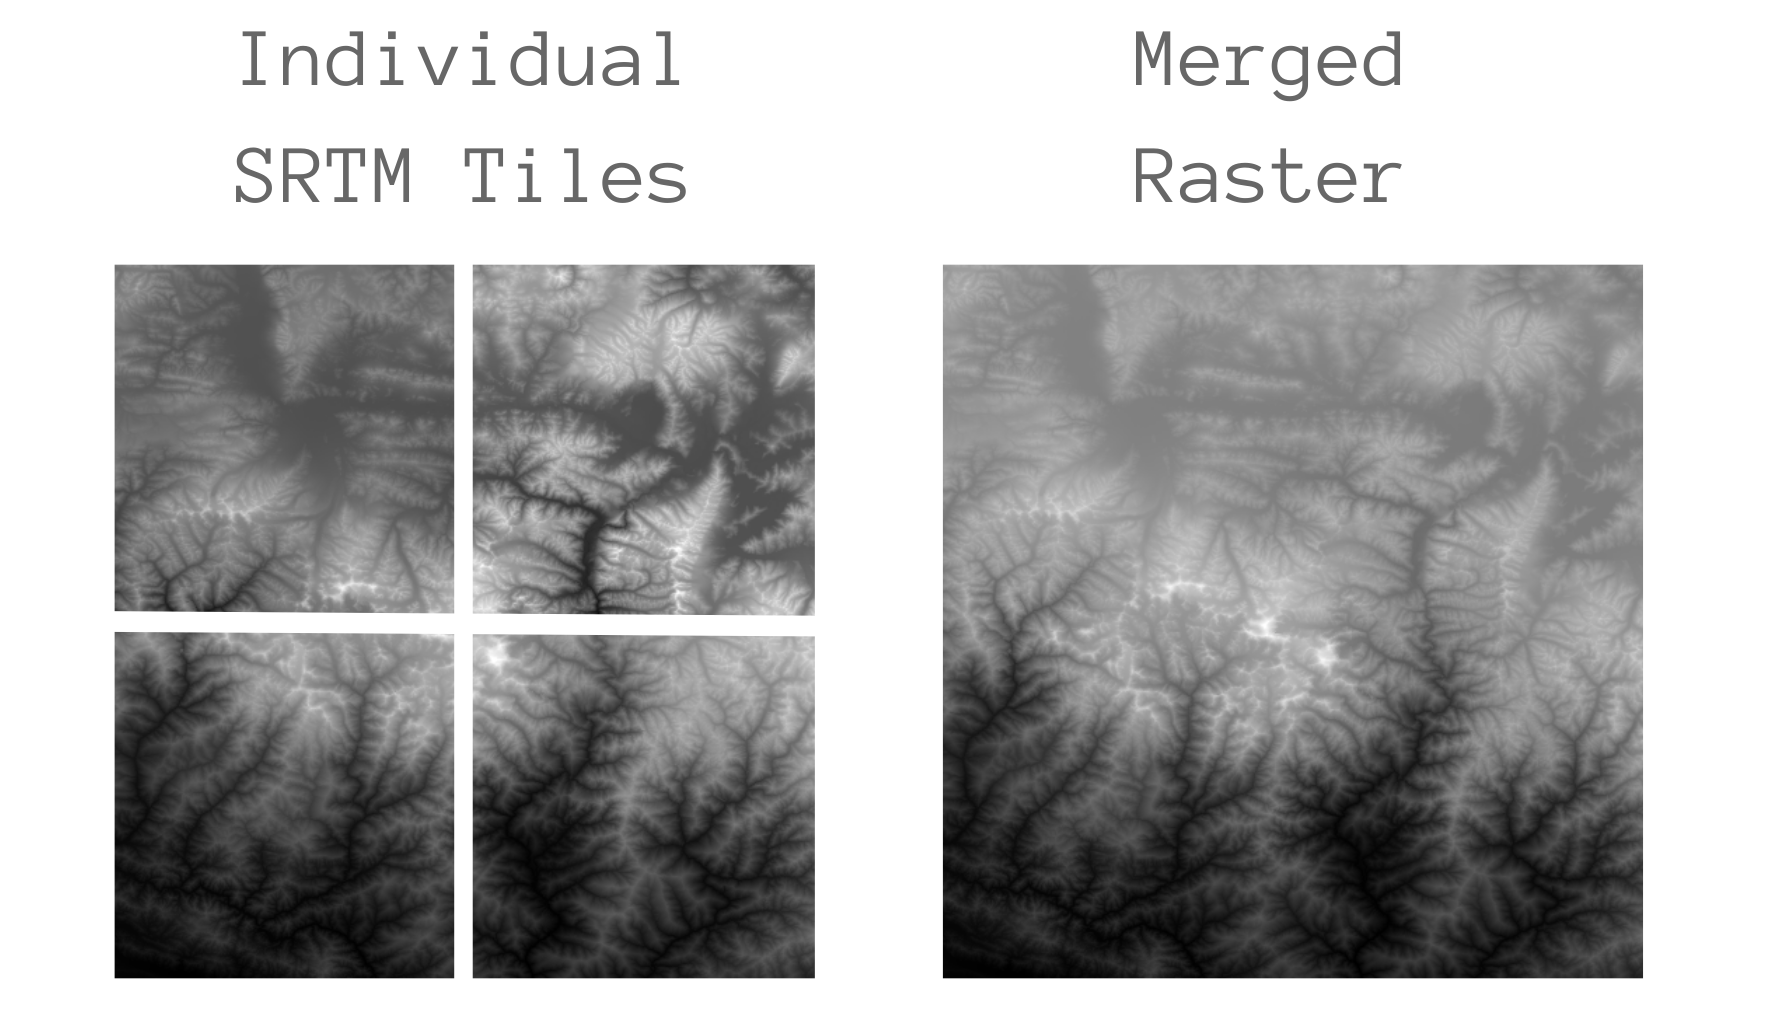

In [1]:
import rasterio

In [2]:
import os
data_pkg_path = 'data'
srtm_dir = 'srtm'
filename = 'N28E087.hgt'
path = os.path.join(data_pkg_path, srtm_dir, filename)

## Reading Raster Data

RasterIO can read any raster format supported by the GDAL library. We can call the `open()` method with the file path of the raster. The resulting dataset behaves much like Python's File object.

In [3]:
dataset = rasterio.open(path)

You can check information about the raster using the `meta` attribute.

An important property is the dataset *transform*. The transform contains the pixel resolution of the dataset and the row and column coordinates of the upper left corner of the dataset.

In [4]:
metadata = dataset.meta
metadata

{'driver': 'SRTMHGT',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 3601,
 'height': 3601,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0002777777777777778, 0.0, 86.99986111111112,
        0.0, -0.0002777777777777778, 29.000138888888888)}

To read the pixel values, we need to call the `read()` method by passing it a band’s index number. Following the GDAL convention, bands are indexed from 1. Since our dataset contain just 1-band, we can read it as follows.

In [5]:
# elevation in metres for each pixel
band1 = dataset.read(1)
print(band1)

[[5217 5211 5208 ... 5097 5098 5089]
 [5206 5201 5200 ... 5080 5075 5069]
 [5199 5194 5191 ... 5063 5055 5048]
 ...
 [5347 5345 5343 ... 5747 5750 5757]
 [5338 5338 5336 ... 5737 5740 5747]
 [5332 5331 5332 ... 5734 5736 5744]]


In [6]:
dataset.shape

(3601, 3601)

Finally, when we are done with the dataset, we must close it. It is especially important when writing a dataset.

In [7]:
dataset.close()

## Merging Datasets

Let's see how we can read the 4 individual tiles and mosaic them together. RasterIO provides multiple sub-modules for various raster operations. We can use the `rasterio.merge` module to carry out this operation.

We first find all the individual files in the directory using the `os.listdir()` function.

In [8]:
srtm_path = os.path.join(data_pkg_path, 'srtm')
all_files = os.listdir(srtm_path)
print(all_files)

['N28E087.hgt', 'N27E087.hgt', 'N27E086.hgt', 'N28E086.hgt']


The rasterio.merge module has a `merge()` method that takes a list of *datasets* and returns the merged dataset. So we create an empty list, open each of the files and append it to the list.

In [9]:
dataset_list = []

for file in all_files:
    path = os.path.join(srtm_path, file)
    dataset_list.append(rasterio.open(path))
print(dataset_list)

[<open DatasetReader name='data/srtm/N28E087.hgt' mode='r'>, <open DatasetReader name='data/srtm/N27E087.hgt' mode='r'>, <open DatasetReader name='data/srtm/N27E086.hgt' mode='r'>, <open DatasetReader name='data/srtm/N28E086.hgt' mode='r'>]


We can pass on the list of tile dataset to the merge method, which will return us the merged data and a new *transform* which contains the updated extent of the merged raster.

In [10]:
from rasterio import merge
merged_result = merge.merge(dataset_list)
print(merged_result)

(array([[[4916, 4926, 4931, ..., 5097, 5098, 5089],
        [4919, 4932, 4928, ..., 5080, 5075, 5069],
        [4919, 4928, 4935, ..., 5063, 5055, 5048],
        ...,
        [ 368,  368,  366, ..., 1905, 1919, 1937],
        [ 364,  364,  362, ..., 1913, 1930, 1944],
        [ 360,  359,  357, ..., 1918, 1930, 1942]]], dtype=int16), Affine(0.0002777777777777778, 0.0, 85.99986111111112,
       0.0, -0.0002777777777777778, 29.000138888888888))


We save the data and the transform to separate variables :

In [11]:
merged_data = merged_result[0]
merged_transform = merged_result[1] # Affine

Verify that the resulting array shape is the sum of individual rasters :

In [12]:
print(merged_data.shape)

(1, 7201, 7201)


## Writing Raster Data

Similar to regular Python files, to create a new file, we can open the output file in the *write* mode. RasterIO provides a `write()` method that we can use to write individual bands.

In [13]:
output_filename = 'merged.tif'
output_dir = 'output'
output_path = os.path.join(output_dir, output_filename)

We need to specify many metadata parameters to initialize the output dataset. Some of these parameter values can be directly copied from the input files, such as `crs`, `dtype`, `nodata` etc. , while others can be obtained from the merged dataset, such as `height` and `width`.

Remember to call the `close()` method which will finalize the file and write the data to disk.

In [14]:
new_dataset = rasterio.open(output_path, 'w', 
                            driver='GTiff',
                            height=merged_data.shape[1],
                            width=merged_data.shape[2],
                            count=1,
                            nodata=-32768.0,
                            dtype=merged_data.dtype,
                            crs='EPSG:4326',
                            transform=merged_transform)
new_dataset.write(merged_data)
new_dataset.close()
print('Successfully written output file at {}'.format(output_path))

Successfully written output file at output/merged.tif


## Exercise

The merged array represents elevation values. The extent of the tiles cover Mt. Everest. Read the resulting raster and find the maximum elevation value contained in it.

## My Solution

In [ ]:
import rasterio
import os
import numpy as np

# config file name and path
output_filename = 'merged.tif'
output_dir = 'output'
path = os.path.join(output_dir, output_filename)

In [67]:
# open file
everest = rasterio.open(path)

In [70]:
# access the metada
everest_meta = everest.meta
everest_meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 7201,
 'height': 7201,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0002777777777777778, 0.0, 85.99986111111112,
        0.0, -0.0002777777777777778, 29.000138888888888)}

Datasets generally have one or more bands (or layers). Following the GDAL convention, these are indexed starting with the number 1. The first band of a file can be read like this:

In [73]:
everest_2d = everest.read(1) # first band

In [74]:
everest_2d.shape

(7201, 7201)

The returned object is a 2-dimensional numpy.ndarray. The representation of that array at the Python prompt is a summary; the GeoTIFF file that Rasterio uses for testing has 0 values in the corners, but has nonzero values elsewhere.

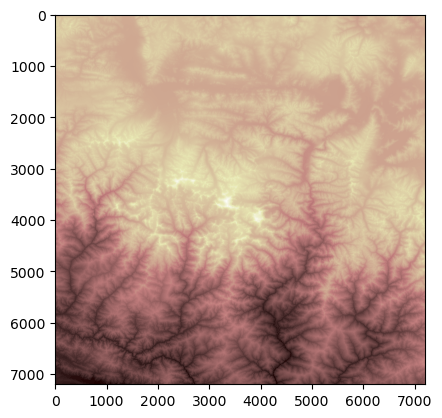

In [75]:
from matplotlib import pyplot
pyplot.imshow(everest_2d, cmap='pink')
pyplot.show()  

Instead of reading single bands, all bands of the input dataset can be read into a 3-dimensonal ndarray. Note that the interpretation of the 3 axes is (`bands`, `rows`, `columns`). See [Image processing software](https://rasterio.readthedocs.io/en/latest/topics/image_processing.html#imageorder) for more details on how to convert to the ordering expected by some software.

In [76]:
everest_3d = src.read()

In [77]:
# bands. rows, columns
everest_3d.shape

(1, 7201, 7201)

In [78]:
max_elevation = np.max(everest_2d)

In [79]:
print (f'The maximum elevation of Mt. Everest is {max_elevation} metres.')

The maximum elevation of Mt. Everest is 8748 metres.
